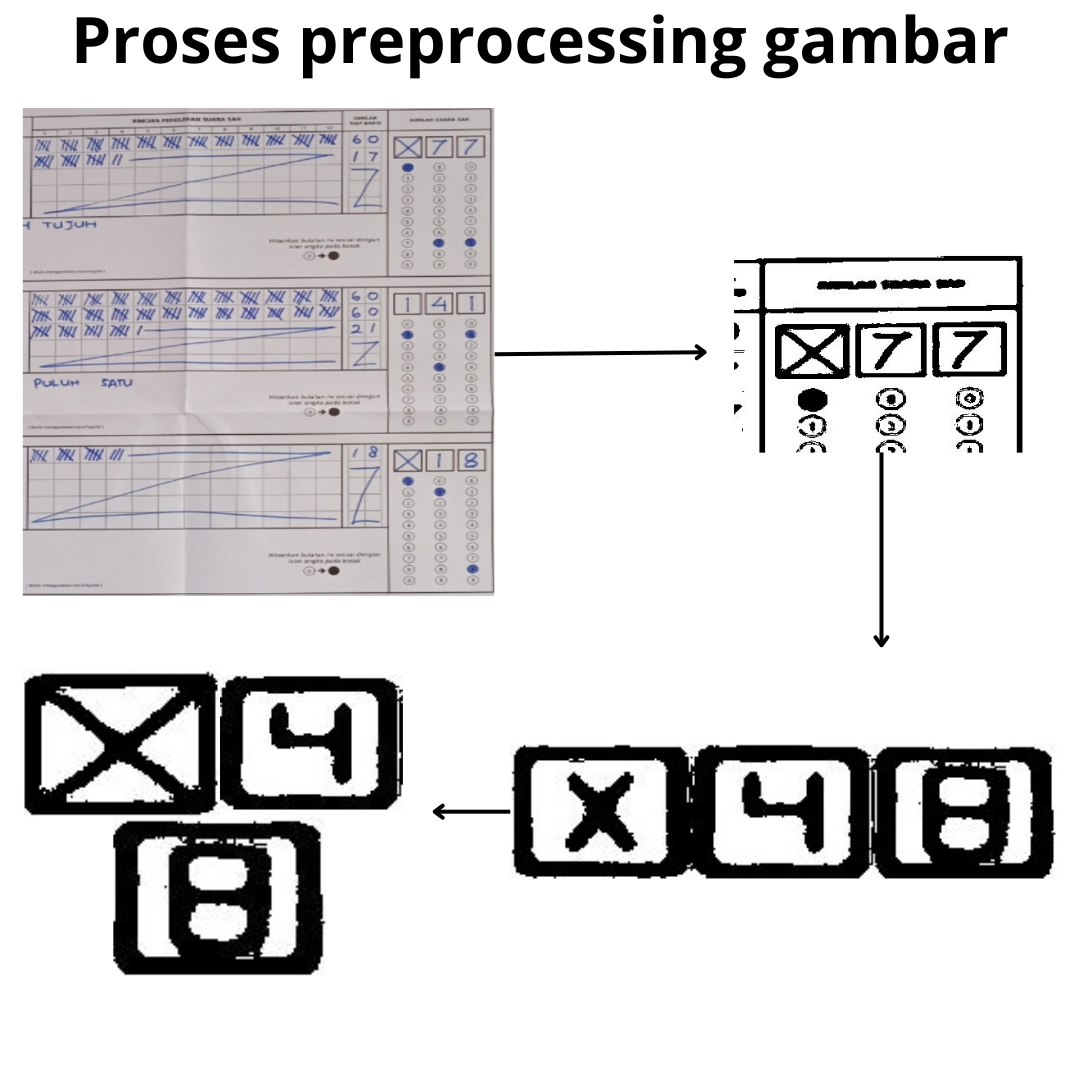

Proses perubahan gambar yang menjadi satuan agar mudah untuk dideteksi dan dilakukan klasifikasi dan disimpan pada data train 6

In [1]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
import pandas as pd
import zipfile
import os
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from transformers import ResNetForImageClassification
from transformers import ResNetConfig
import transformers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.models import load_model
from keras.preprocessing import image
import ipywidgets as widgets
from IPython.display import display, Image, clear_output
# from tensorflow.keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input

2024-04-26 13:22:02.441231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 13:22:02.441376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 13:22:02.570009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Prepocess Dataframe Label

In [2]:
import pandas as pd

# Baca file TSV ke dalam DataFrame pandas
df = pd.read_csv("/kaggle/input/label2/label.csv")

# Tampilkan DataFrame
df

,tps,suara_paslon_1,suara_paslon_2,suara_paslon_3
0,TPS_001,159,9,2
1,TPS_002,112,87,2
2,TPS_003,173,27,3
3,TPS_004,207,20,3
4,TPS_005,213,30,4
...,...,...,...,...
495,TPS_496,11,150,60
496,TPS_497,20,105,18
497,TPS_498,11,168,24
498,TPS_499,39,130,32


In [3]:
# Rename columns
df = df.rename(columns={
    'suara_paslon_1': 'suara_paslon_01',
    'suara_paslon_2': 'suara_paslon_02',
    'suara_paslon_3': 'suara_paslon_03'
})
# Duplicate the tps column for three rows
df = df.loc[df.index.repeat(3)].reset_index(drop=True)

# Add suffix to the tps column
df['tps'] = df.apply(lambda x: f'{x["tps"]}_{x.name % 3 + 1:02d}', axis=1)
# Combine suara_paslon_1, suara_paslon_2, and suara_paslon_3 based on tps suffix
df['suara_paslon'] = df.apply(lambda x: x[f'suara_paslon_{x["tps"][-2:]}'], axis=1)

# Rearrange the columns
df = df[['tps', 'suara_paslon']]
# Menambahkan nol di depan angka pada kolom suara_paslon
df['suara_paslon'] = df['suara_paslon'].astype(str).str.zfill(3)

df['suara_paslon'] = df['suara_paslon'].apply(lambda x: [int(digit) for digit in str(x)])
df = df.explode('suara_paslon').reset_index(drop=True)
# Mengganti kode akhir untuk nama TPS yang sama
df['count'] = df.groupby('tps').cumcount() + 1
df['tps'] = df['tps'] + '_' + df['count'].astype(str).str.zfill(2)
df = df.drop(columns='count')
df

,tps,suara_paslon
0,TPS_001_01_01,1
1,TPS_001_01_02,5
2,TPS_001_01_03,9
3,TPS_001_02_01,0
4,TPS_001_02_02,0
...,...,...
4495,TPS_500_02_02,3
4496,TPS_500_02_03,0
4497,TPS_500_03_01,0
4498,TPS_500_03_02,3


# Prepocess Gambar

In [4]:
import cv2
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array

# Load and preprocess images
images = []
for file_name in df['tps']:
    image_path = f"/kaggle/input/data-baru-4/DataTrain6/{file_name}.jpg"  # Adjust the path as per your directory structure
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    load_image = load_img(image_path, target_size=(224, 224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr / 255.0  # Normalization
    images.append(norm_load_image_arr)


In [5]:
from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
df['suara_paslon_encoded'] = label_encoder.fit_transform(df['suara_paslon'])
df['suara_paslon_encoded']

0       1
1       5
2       9
3       0
4       0
       ..
4495    3
4496    0
4497    0
4498    3
4499    7
Name: suara_paslon_encoded, Length: 4500, dtype: int64

In [6]:
X = np.array(images,dtype=np.float32)
y = np.array(df['suara_paslon_encoded'])    # Target variable

# Menggunakan numpy array
y = label_encoder.fit_transform(y)

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3600, 224, 224, 3), (900, 224, 224, 3), (3600,), (900,))

# Membuat model

In [7]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

# Define the input shape
inputs = Input(shape=(224, 224, 3), name='input_layer')

# Get the output of the base_model
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
# Add a Dense layer with 10 units (assuming 10 classes) and softmax activation
x = Dense(10, activation='softmax', name='output_layer')(x)

# Create a new model
model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30


I0000 00:00:1714137848.044074     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714137848.149888     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.7739 - loss: 0.7139

W0000 00:00:1714137903.567425     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 136s 538ms/step - accuracy: 0.7750 - loss: 0.7109 - val_accuracy: 0.3667 - val_loss: 2.1974
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - accuracy: 0.9737 - loss: 0.1019 - val_accuracy: 0.3667 - val_loss: 3.3358
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.9795 - loss: 0.0707 - val_accuracy: 0.3667 - val_loss: 10.3024
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.9881 - loss: 0.0445 - val_accuracy: 0.3667 - val_loss: 4.5819
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.9960 - loss: 0.0160 - val_accuracy: 0.3667 - val_loss: 7.7594
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.9889 - loss: 0.0402 - val_accuracy: 0.7389 - val_loss: 0.8090
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - accuracy: 0.9917 - loss: 0.0300 - val_accuracy: 0.8800 - val_loss: 0.3899
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.9828 - loss: 0.0468 - v

# Test hasil Model

In [8]:
# Generate predictions for the test set
predictions = model.predict(X_test)
# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Display some predictions with file names
for i in range(20):  # Adjust the range as needed
    file_name = df['tps'].iloc[i]
    print(f"File: {file_name}, Predicted label: {predicted_labels[i]}, Actual label: {y_test[i]}")

 5/29 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

W0000 00:00:1714138460.989933     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step
File: TPS_001_01_01, Predicted label: 2, Actual label: 2
File: TPS_001_01_02, Predicted label: 0, Actual label: 0
File: TPS_001_01_03, Predicted label: 8, Actual label: 8
File: TPS_001_02_01, Predicted label: 4, Actual label: 4
File: TPS_001_02_02, Predicted label: 1, Actual label: 1
File: TPS_001_02_03, Predicted label: 1, Actual label: 1
File: TPS_001_03_01, Predicted label: 0, Actual label: 5
File: TPS_001_03_02, Predicted label: 1, Actual label: 1
File: TPS_001_03_03, Predicted label: 2, Actual label: 2
File: TPS_002_01_01, Predicted label: 0, Actual label: 0
File: TPS_002_01_02, Predicted label: 0, Actual label: 0
File: TPS_002_01_03, Predicted label: 9, Actual label: 9
File: TPS_002_02_01, Predicted label: 0, Actual label: 0
File: TPS_002_02_02, Predicted label: 8, Actual label: 8
File: TPS_002_02_03, Predicted label: 0, Actual label: 0
File: TPS_002_03_01, Predicted label: 0, Actual label: 0
File: TPS_002_03_02, Predicted label: 4, Actual

# Menguji pada data test

In [9]:
import pandas as pd

# List of file names
file_names = [f"TPS_{i:03}_{j:02}" for i in range(501, 701) for j in range(1, 4)]

# Create a DataFrame with 'tps' column
df_test = pd.DataFrame({"tps": file_names})

# Display the DataFrame
df_test


,tps
0,TPS_501_01
1,TPS_501_02
2,TPS_501_03
3,TPS_502_01
4,TPS_502_02
...,...
595,TPS_699_02
596,TPS_699_03
597,TPS_700_01
598,TPS_700_02


In [10]:
# Duplicate the tps column for three rows
df_test = df_test.loc[df_test.index.repeat(3)].reset_index(drop=True)

# Add suffix to the tps column
df_test['tps'] = df_test['tps'] + '_' + ((df_test.index % 3) + 1).astype(str).str.zfill(2)

# Mengganti kode akhir untuk nama TPS yang sama
df_test['count'] = df_test.groupby('tps').cumcount() + 1
df_test = df_test.drop(columns='count')

df_test

,tps
0,TPS_501_01_01
1,TPS_501_01_02
2,TPS_501_01_03
3,TPS_501_02_01
4,TPS_501_02_02
...,...
1795,TPS_700_02_02
1796,TPS_700_02_03
1797,TPS_700_03_01
1798,TPS_700_03_02


In [11]:
import cv2
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array

# Load and preprocess images
images_test = []
for file_name in df_test['tps']:
    image_path = f"/kaggle/input/data-baru-4/DataTest6/{file_name}.jpg"  # Adjust the path as per your directory structure
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    load_image = load_img(image_path, target_size=(224, 224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr / 255.0  # Normalization
    images_test.append(norm_load_image_arr)


In [12]:
X = np.array(images_test,dtype=np.float32)

In [13]:
# Make predictions on the test set
y_pred_test = model.predict(X)
predicted_labels = np.argmax(y_pred_test, axis=1)
predicted_labels

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step


array([0, 7, 7, ..., 0, 3, 1])

In [14]:
import pandas as pd

# Assuming y_pred_rf is a Series or 1D array of predictions
# Create a DataFrame from y_pred_rf
df_predicted_labels = pd.DataFrame({"prediction": predicted_labels})

# Concatenate df and df_pred along the columns axis
df_combined = pd.concat([df_test, df_predicted_labels], axis=1)

df_combined


,tps,prediction
0,TPS_501_01_01,0
1,TPS_501_01_02,7
2,TPS_501_01_03,7
3,TPS_501_02_01,1
4,TPS_501_02_02,4
...,...,...
1795,TPS_700_02_02,2
1796,TPS_700_02_03,1
1797,TPS_700_03_01,0
1798,TPS_700_03_02,3


In [15]:
# Menggabungkan prediksi berdasarkan kode TPS
df_combined['tps_group'] = df_combined['tps'].apply(lambda x: x[:10])
df_combined['group_prediction'] = df_combined.groupby('tps_group')['prediction'].transform(lambda x: ''.join(map(str, x.astype(int))))
df_result = df_combined.drop_duplicates('tps_group')[['tps_group', 'group_prediction']].reset_index(drop=True)
df_result

,tps_group,group_prediction
0,TPS_501_01,077
1,TPS_501_02,141
2,TPS_501_03,018
3,TPS_502_01,125
4,TPS_502_02,098
...,...,...
595,TPS_699_02,165
596,TPS_699_03,043
597,TPS_700_01,063
598,TPS_700_02,121


In [16]:
# Mengambil angka dari setiap TPS
df_result['tps_number'] = df_result['tps_group'].str.extract(r'TPS_(\d+)_\d+')
df_result

,tps_group,group_prediction,tps_number
0,TPS_501_01,077,501
1,TPS_501_02,141,501
2,TPS_501_03,018,501
3,TPS_502_01,125,502
4,TPS_502_02,098,502
...,...,...,...
595,TPS_699_02,165,699
596,TPS_699_03,043,699
597,TPS_700_01,063,700
598,TPS_700_02,121,700


In [17]:
df_result['group_prediction'] = df_result['group_prediction'].astype(int)
# Menghitung total suara per tps_number
total_suara_per_tps_number = df_result.groupby('tps_number')['group_prediction'].transform('sum')

# Menghitung persentase 02 dari total suara untuk setiap baris
df_result['Persentase Suara Sah Paslon 2'] = (df_result['group_prediction'] / total_suara_per_tps_number) * 100
# Filter hanya baris dengan tps yang berakhir dengan '02'
df_result = df_result[df_result['tps_group'].str.endswith('02')]
df_result

,tps_group,group_prediction,tps_number,Persentase Suara Sah Paslon 2
1,TPS_501_02,141,501,59.745763
4,TPS_502_02,98,502,41.702128
7,TPS_503_02,165,503,72.052402
10,TPS_504_02,153,504,71.162791
13,TPS_505_02,172,505,71.074380
...,...,...,...,...
586,TPS_696_02,91,696,92.857143
589,TPS_697_02,158,697,68.398268
592,TPS_698_02,144,698,77.419355
595,TPS_699_02,165,699,79.326923


In [18]:
# Rename columns
df_result = df_result.rename(columns={
    'tps_group': 'TPS'
})
df_result = df_result[['TPS', 'Persentase Suara Sah Paslon 2']]
# Menghapus '_02' dari setiap nama TPS
df_result['TPS'] = df_result['TPS'].str.replace('_02', '')
df_result

,TPS,Persentase Suara Sah Paslon 2
1,TPS_501,59.745763
4,TPS_502,41.702128
7,TPS_503,72.052402
10,TPS_504,71.162791
13,TPS_505,71.074380
...,...,...
586,TPS_696,92.857143
589,TPS_697,68.398268
592,TPS_698,77.419355
595,TPS_699,79.326923


In [19]:
df_result.to_csv('hasil.csv', index=False)